<a href="https://colab.research.google.com/github/MANOJHRMANOJHR/ai_assignments/blob/main/mnist_mlp_vs_logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Logistic baseline test accuracy: 0.9244
Keras MLP test accuracy: 0.9682


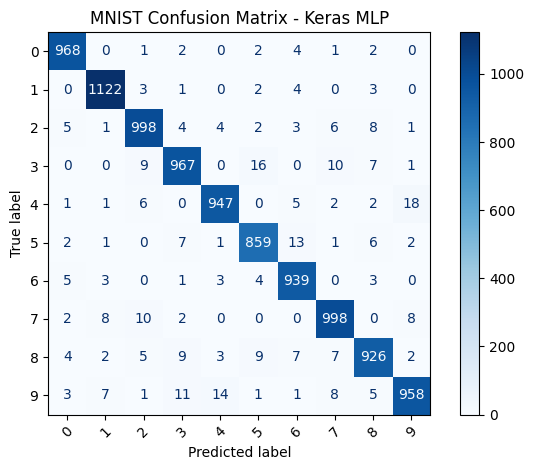

Saved: outputs/mnist/cm_mlp.png


In [2]:
# mnist_mlp_vs_logistic.py
# Keras MLP (dropout + early stopping) on MNIST, compared to a Logistic baseline.
# Saves confusion matrix for the MLP.
#
# If offline: place a local 'mnist.npz' next to this script (from Keras cache),
# the loader will use it automatically.

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping


def ensure_out():
    os.makedirs("outputs/mnist", exist_ok=True)


def main():
    ensure_out()

    # tf.keras automatically uses ~/.keras/datasets/mnist.npz or downloads if missing
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

    # ----- Logistic baseline -----
    X_train_flat = X_train.reshape((X_train.shape[0], -1)).astype("float32") / 255.0
    X_test_flat = X_test.reshape((X_test.shape[0], -1)).astype("float32") / 255.0

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_test_scaled = scaler.transform(X_test_flat)

    logreg = LogisticRegression(solver="saga",
                                max_iter=200, n_jobs=-1)
    logreg.fit(X_train_scaled, y_train)
    y_pred_lr = logreg.predict(X_test_scaled)
    acc_lr = accuracy_score(y_test, y_pred_lr)
    print(f"Logistic baseline test accuracy: {acc_lr:.4f}")

    # ----- MLP with dropout + early stopping -----
    X_train_n = (X_train.astype("float32") / 255.0)
    X_test_n = (X_test.astype("float32") / 255.0)

    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(10, activation="softmax")
    ])

    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    es = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)
    model.fit(X_train_n, y_train, validation_split=0.1, epochs=5,
              batch_size=128, callbacks=[es], verbose=0)

    test_loss, test_acc = model.evaluate(X_test_n, y_test, verbose=0)
    print(f"Keras MLP test accuracy: {test_acc:.4f}")

    # Confusion matrix for MLP
    y_pred_mlp = np.argmax(model.predict(X_test_n, verbose=0), axis=1)
    cm = confusion_matrix(y_test, y_pred_mlp)
    disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(10))
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("MNIST Confusion Matrix - Keras MLP")
    plt.tight_layout()
    plt.savefig("outputs/mnist/cm_mlp.png", dpi=200)
    plt.show()
    print("Saved: outputs/mnist/cm_mlp.png")


if __name__ == "__main__":
    main()
